In [1]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math

In [2]:
db_connection = sql.connect(host='localhost', database='collection_visits', user='pandas', password='password')

pensActivity = pd.read_sql('SELECT * FROM PensActivity', con=db_connection)
pensActivity['created'] = pd.to_datetime(pensActivity['created'], unit='s')
pensActivity['lastmodified'] = pd.to_datetime(pensActivity['lastmodified'], unit='s')
pensActivity['created'].replace(0, np.nan, inplace=True)
pensActivity['lastmodified'].replace(0, np.nan, inplace=True)
pensActivity['notes'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
pensActivity['notes'] = pensActivity['notes'].astype('category')
pensActivity.sort_values(by='created', inplace=True)

pensCheckouts = pd.read_sql('SELECT * FROM PensCheckouts', con=db_connection)
pensCheckouts['start'] = pd.to_datetime(pensCheckouts['start'], unit='s')
pensCheckouts['start'].replace(0, np.nan, inplace=True)
pensCheckouts['end'].replace(0, np.nan, inplace=True)
pensCheckouts['end'] = pd.to_datetime(pensCheckouts['end'], unit='s')
pensCheckouts['start_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['end_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['start_ip'] = pensCheckouts['start_ip'].astype('category')
pensCheckouts['end_ip'] = pensCheckouts['end_ip'].astype('category')

pensCheckouts.set_index('id', inplace=True)
pensCheckouts.sort_index(inplace=True)
###DROPED COLUMNS####
pensCheckouts.drop(['start_ip', 'end_ip'], axis=1, inplace=True)

In [98]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

## comparing number of uses

In [130]:
activity_id = pensActivity['pen_id']
activity_id_count = activity_id.value_counts()
activity_id_count = activity_id_count.rename('value_pens_activity')
# activity_id_count = activity_id_count.to_frame()
# activity_id_count.reset_index(inplace=True)
# activity_id_count = activity_id_count.rename({ 'index': 'pen_id_activity', 'pen_id':'value_pens_activity'}, axis='columns')

In [129]:
checkout_id = pensCheckouts['pen_id']
checkout_id_count = checkout_id.value_counts()
checkout_id_count = checkout_id_count.rename('value_pens_checkout')
# checkout_id_count = checkout_id_count.to_frame()
# checkout_id_count.reset_index(inplace=True)
# checkout_id_count =checkout_id_count.rename({ 'index': 'pen_id_checkout', 'pen_id':'value_pens_checkout'}, axis='columns')

In [63]:
same_id = checkout_id_count.merge(activity_id_count, left_on='pen_id_checkout', right_on='pen_id_activity')
same_id

,pen_id_checkout,value_pens_checkout,pen_id_activity,value_pens_activity
0,1525511,826,1525511,1288
1,1519959,721,1519959,1104
2,1523121,717,1523121,1184
3,1521555,715,1521555,1107
4,1523605,670,1523605,1093
...,...,...,...,...
3002,1526873,1,1526873,1
3003,1520931,1,1520931,1
3004,1524877,1,1524877,2
3005,1521759,1,1521759,1


In [131]:
ids = pd.concat([checkout_id_count, activity_id_count], axis=1, sort=False)

ids

,value_pens_checkout,value_pens_activity
0,2.0,1.0
1,6.0,NaN
2,7.0,NaN
3,49.0,1.0
4,5.0,NaN
...,...,...
3860045,130.0,267.0
3860047,84.0,180.0
3860067,466.0,629.0
3860071,100.0,185.0


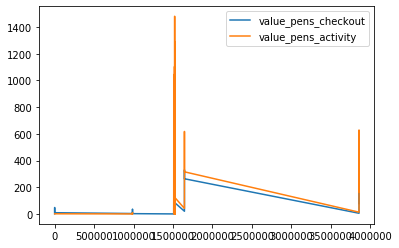

In [132]:
ids.plot()

## why 2017 is less popular in checkout but more active in activity 

In [88]:
checkout_monthly_value = pensCheckouts['start'].groupby(pensCheckouts.start.dt.to_period("M")).agg('count')
# checkout_monthly_value = checkout_monthly_value.to_frame().rename({'start': "time_count"}, axis=1)
# checkout_monthly_value.reset_index(inplace=True)
checkout_monthly_value

start
2014-10      20
2014-11     154
2014-12      63
2015-01      30
2015-02     126
           ... 
2019-12    9811
2020-01    9066
2020-02    7595
2020-03     854
2020-07      36
Freq: M, Name: start, Length: 67, dtype: int64

In [89]:
activity_monthly_value = pensActivity['created'].groupby(pensActivity.created.dt.to_period("M")).agg('count')
# activity_monthly_value = activity_monthly_value.to_frame().rename({'created': 'time_count'}, axis=1)
# activity_monthly_value.reset_index(inplace=True)
activity_monthly_value

created
2014-12       52
2015-01       27
2015-02      760
2015-03    16414
2015-04    19576
           ...  
2020-02     6327
2020-03      716
2020-04        5
2020-06        1
2020-07        9
Freq: M, Name: created, Length: 67, dtype: int64

In [138]:
join_monthly_value = pd.concat([checkout_monthly_value, activity_monthly_value], axis=1)
join_monthly_value = join_monthly_value.rename({'start': 'checkout_counts', 'created': 'activity_counts'}, axis=1)
join_monthly_value

,checkout_counts,activity_counts
2014-10,20.0,NaN
2014-11,154.0,NaN
2014-12,63.0,52.0
2015-01,30.0,27.0
2015-02,126.0,760.0
2015-03,8768.0,16414.0
2015-04,14520.0,19576.0
2015-05,12994.0,15887.0
2015-06,9820.0,11692.0
2015-07,12118.0,16733.0


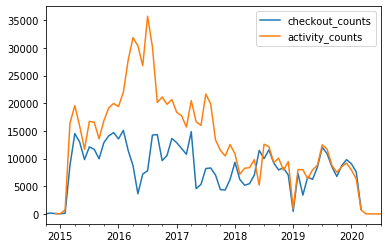

In [96]:
join_monthly_value.plot()

In [ ]:
#nlargest of activity values and checkout values in comapre to the exhibition